# Transformer for Classify

このNotebookでは、Tensorflowのチュートリアルにある［言語理解のためのTransoformerモデル］を、  
分類タスク用にコードを修正したものです。　　

URL「Transformer model for language understanding」  
https://www.tensorflow.org/tutorials/text/transformer?hl=ja#top_of_page　　

※Python、機械学習ともに初学者のため、間違いがある場合にはアドバイスいただけますと助かります。

## Analysis base

OSのフォルダは、以下のような構成を想定しています。
* /tf
    * /input
        * /data
        * /encoder
    * /output/checkponts
    * /notebook

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

import tarfile 
import glob
import os
import pandas as pd
from urllib.request import urlretrieve

import re
import mojimoji as mojimoji
from pyknp import Juman
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import time
import numpy as np
import matplotlib.pyplot as plt

## Setup input pipeline

データは［livedoor ニュースコーパス］を利用します。  

URL「livedoor ニュースコーパス」  
https://www.rondhuit.com/download.html#ldcc

### ニュースコーパスをダウンロードしてファイルを展開しall.csvを作成

In [2]:
FILEURL = "https://www.rondhuit.com/download/ldcc-20140209.tar.gz"
FILEPATH = "../input/data/tmp/ldcc-20140209.tar.gz"
TEXTDIR = "../input/data/livedoor/"
DATADIR = "../input/data/"

In [335]:
urlretrieve(FILEURL, FILEPATH)

mode = "r:gz"
tar = tarfile.open(FILEPATH, mode) 
tar.extractall(TEXTDIR ) 
tar.close()

In [336]:
def extract_txt(filename):
    with open(filename) as text_file:
        # 0: URL, 1: timestamp
        text = text_file.readlines()[2:]
        text = [sentence.strip() for sentence in text]
        text = list(filter(lambda line: line != '', text))
        return ''.join(text)

In [337]:
categories = [ 
    name for name 
    in os.listdir( os.path.join(TEXTDIR, "text") ) 
    if os.path.isdir( os.path.join(TEXTDIR, "text", name) ) ]

categories = sorted(categories)

In [338]:
categories

['dokujo-tsushin',
 'it-life-hack',
 'kaden-channel',
 'livedoor-homme',
 'movie-enter',
 'peachy',
 'smax',
 'sports-watch',
 'topic-news']

In [339]:
table = str.maketrans({
    '\n': '',
    '\t': '　',
    '\r': '',
})

In [340]:
all_text = []
all_label = []

for cat in categories:
    files = glob.glob(os.path.join(TEXTDIR, "text", cat, "{}*.txt".format(cat)))
    files = sorted(files)
    body = [ extract_txt(elem).translate(table) for elem in files ]
    label = [cat] * len(body)
    
    all_text.extend(body)
    all_label.extend(label)

In [341]:
df = pd.DataFrame({'text' : all_text, 'label' : all_label})

In [342]:
df.to_csv(os.path.join(DATADIR, "all.csv"), header=True, index=False)

### 前処理をして、文章を単語に分け、トークン化用のencoderを作成

In [343]:
df = pd.read_csv(os.path.join(DATADIR, "all.csv"))

In [4]:
ENCPATH = "../input/encoder/livedoor"

In [66]:
def preprocessing(text):
        
    table = str.maketrans({
        '\n': '',
        '\t': '　',
        '\r': '',
    })
        
    text = text.translate(table)
    text = text.lower()
    text = re.sub(r'\d+', '0', text)
    text = mojimoji.han_to_zen(text)
    text = re.sub('[!"#$%&\'\\\\()*+,-./:;<=>?@[\\]^_`{|}~「」〔〕“”〈〉『』【】＆＊・（）＄＃＠。、？！｀＋￥％]', '', text)
    
    while len(text.encode('utf-8')) > 4096:
        text = text[:-1]
    
    return text

In [67]:
def parse(text):
    
    split_list = []
    jumanpp = Juman()
    result = jumanpp.analysis(text)
    for mrph in result.mrph_list():
        split_list.append(mrph.midasi)
        split_str = '　'.join(split_list)
    
    return split_str

In [347]:
df["pre_text"] = df["text"].apply(preprocessing)

In [348]:
df["tokens"] = df["pre_text"].apply(parse)

In [351]:
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(df.label.values)

df["target"]  = y

In [352]:
df.head()

,text,label,pre_text,tokens,target
0,友人代表のスピーチ、独女はどうこなしている？もうすぐジューン・ブライドと呼ばれる６月。独女の...,dokujo-tsushin,友人代表のスピーチ独女はどうこなしているもうすぐジューンブライドと呼ばれる０月独女の中には自...,友人 代表 の スピーチ 独女 は どう こなして いる もう すぐ ジューンブライド と ...,0
1,ネットで断ち切れない元カレとの縁携帯電話が普及する以前、恋人への連絡ツールは一般電話が普通だ...,dokujo-tsushin,ネットで断ち切れない元カレとの縁携帯電話が普及する以前恋人への連絡ツールは一般電話が普通だっ...,ネット で 断ち切れ ない 元 カレ と の 縁 携帯 電話 が 普及 する 以前 恋人 へ...,0
2,相次ぐ芸能人の“すっぴん”披露 その時、独女の心境は？「男性はやっぱり、女性の“すっぴん”が...,dokujo-tsushin,相次ぐ芸能人のすっぴん披露 その時独女の心境は男性はやっぱり女性のすっぴんが大好きなんですか...,相次ぐ 芸能 人 の すっぴん 披露 その 時 独女 の 心境 は 男性 は やっぱり ...,0
3,ムダな抵抗！？ 加齢の現実ヒップの加齢による変化は「たわむ→下がる→内に流れる」、バストは「...,dokujo-tsushin,ムダな抵抗 加齢の現実ヒップの加齢による変化はたわむ→下がる→内に流れるバストはそげる→たわ...,ムダな 抵抗 加齢 の 現実 ヒップ の 加齢 に よる 変化 は たわむ → 下がる ...,0
4,税金を払うのは私たちなんですけど！6月から支給される子ども手当だが、当初は子ども一人当たり月...,dokujo-tsushin,税金を払うのは私たちなんですけど０月から支給される子ども手当だが当初は子ども一人当たり月額０...,税金 を 払う の は 私 たち な んです けど ０ 月 から 支給 さ れる 子ども 手...,0


In [353]:
df.to_csv(os.path.join(DATADIR, "all_tokens.csv"), header=True, index=False)

In [354]:
dataset = tf.data.Dataset.from_tensor_slices((df.tokens.values, df.target.values))

In [355]:
tokenizer = tfds.features.text.Tokenizer(alphanum_only=False)

vocabulary_set = set()
for text_tensor, _ in dataset:
  some_tokens = tokenizer.tokenize(text_tensor.numpy())
  vocabulary_set.update(some_tokens)

len(vocabulary_set)

77197

Note: PCスペックに応じてvocabularyリストのトークン数を削減（高PCスペックの場合は不要）

In [43]:
while  len(vocabulary_set) > 32000 :
    vocabulary_set.pop()

len(vocabulary_set)

In [356]:
encoder = tfds.features.text.TokenTextEncoder(vocabulary_set)

In [357]:
encoder.save_to_file(ENCPATH)

##### target と label のリストを保存

In [358]:
target_list = df[['target', 'label']]

In [360]:
target_list = target_list.drop_duplicates()

In [361]:
target_list .head()

,target,label
0,0,dokujo-tsushin
870,1,it-life-hack
1740,2,kaden-channel
2604,3,livedoor-homme
3115,4,movie-enter


In [362]:
target_list.to_csv(os.path.join(DATADIR, "target_list.csv"), header=True, index=False)

##### encoder のテスト

In [5]:
encoder = tfds.features.text.TokenTextEncoder.load_from_file(ENCPATH)

In [364]:
example_text = next(iter(dataset))[0].numpy().decode('utf-8')
print(example_text)

友人　代表　の　スピーチ　独女　は　どう　こなして　いる　もう　すぐ　ジューンブライド　と　呼ば　れる　０　月　独女　の　中　に　は　自分　の　式　は　まだ　な　の　に　呼ば　れて　ばかり　……　と　いう　お　祝い　貧乏　状態　の　人　も　多い　ので　は　ない　だろう　か　　　さらに　出席　回数　を　重ねて　いく　と　こんな　お　願い　ごと　を　さ　れる　こと　も　少なく　ない　お　願い　が　ある　んだ　けど　……　友人　代表　の　スピーチ　やって　くれ　ない　か　な　さて　そんな　とき　独女　は　どう　対応　したら　いい　か　最近　だ　と　インターネット　等　で　検索　すれば　友人　代表　スピーチ　用　の　例文　サイト　が　たくさん　出て　くる　ので　それ　ら　を　参考　に　すれば　無難な　もの　は　誰　でも　作成　できる　しかし　由利　さん　０　歳　は　ネット　を　参考　に　して　作成　した　もの　の　これ　で　本当に　いい　の　か　不安でした　一　人　暮らし　な　ので　聞か　せて　感想　を　いって　くれる　人　も　い　ない　しか　と　いって　他　の　友人　に　わざわざ　聞か　せる　の　も　どう　か　と　思う　し　……　と　いう　こと　で　活用　した　の　が　なんと　インターネット　の　悩み　相談　サイト　に　そこ　に　作成　した　スピーチ　文　を　掲載　し　これ　で　大丈夫　か　添削　して　ください　と　メッセージ　を　送った　と　いう　のである　一晩　で　０　人　位　の　人　が　添削　して　くれ　ました　よち　なみ　に　自分　以外　に　も　そういう　人　は　たくさん　いて　その　相談　サイト　に　は　同じ　ように　添削　を　お　願い　する　投稿　が　いっぱい　あり　ました　由利　さん　ためしに　教えて　もらった　その　サイト　を　みて　みる　と　確かに　結婚　式　の　スピーチ　の　添削　お　願い　し　ます　と　いう　投稿　が　０　件　を　超える　くらい　あった　めでたい　結婚　式　の　影　で　こんな　ネット　コミュニティ　が　あった　と　は　知ら　なかった　しかし　事前　に　お　願い　さ　れる　スピーチ　なら　準備　が　できる　し　まだ　いい　です　よ　一番　嫌な　の　は　何といっても　サプライズ　スピーチ　と　語る　の　は　昨年　だけ　で　０万　以上　お　

In [365]:
encoded_example = encoder.encode(example_text)
print(encoded_example)

[42519, 57222, 60965, 48015, 51126, 18181, 55446, 24038, 74918, 6284, 37896, 59564, 22257, 5410, 46674, 5214, 37313, 51126, 60965, 48146, 30590, 18181, 76050, 60965, 12993, 18181, 41876, 57490, 60965, 30590, 5410, 31473, 2416, 22257, 53285, 15787, 7080, 31104, 31552, 60965, 31940, 59272, 6070, 48454, 18181, 14454, 73147, 42865, 50285, 34667, 45124, 62978, 31870, 4309, 22257, 21542, 15787, 53372, 47175, 62978, 29377, 46674, 56276, 59272, 9637, 14454, 15787, 53372, 64586, 48232, 48768, 67637, 42519, 57222, 60965, 48015, 7243, 51994, 14454, 42865, 57490, 55698, 70859, 38248, 51126, 18181, 55446, 58687, 75393, 42851, 42865, 28051, 70050, 22257, 35256, 41967, 75433, 12202, 70954, 42519, 57222, 48015, 20797, 60965, 72348, 23812, 64586, 16447, 57583, 7989, 48454, 9038, 54171, 62978, 15741, 30590, 70954, 37518, 76867, 18181, 5002, 26303, 50545, 19365, 75436, 15508, 28195, 5214, 65593, 18181, 30117, 62978, 15741, 30590, 56203, 50545, 72823, 76867, 60965, 57889, 75433, 27092, 42851, 60965, 42865

##### train.csv valid.csv を作成

In [6]:
df = pd.read_csv(os.path.join(DATADIR, "all_tokens.csv"))

In [7]:
df.head()

,text,label,pre_text,tokens,target
0,友人代表のスピーチ、独女はどうこなしている？もうすぐジューン・ブライドと呼ばれる６月。独女の...,dokujo-tsushin,友人代表のスピーチ独女はどうこなしているもうすぐジューンブライドと呼ばれる０月独女の中には自...,友人 代表 の スピーチ 独女 は どう こなして いる もう すぐ ジューンブライド と ...,0
1,ネットで断ち切れない元カレとの縁携帯電話が普及する以前、恋人への連絡ツールは一般電話が普通だ...,dokujo-tsushin,ネットで断ち切れない元カレとの縁携帯電話が普及する以前恋人への連絡ツールは一般電話が普通だっ...,ネット で 断ち切れ ない 元 カレ と の 縁 携帯 電話 が 普及 する 以前 恋人 へ...,0
2,相次ぐ芸能人の“すっぴん”披露 その時、独女の心境は？「男性はやっぱり、女性の“すっぴん”が...,dokujo-tsushin,相次ぐ芸能人のすっぴん披露 その時独女の心境は男性はやっぱり女性のすっぴんが大好きなんですか...,相次ぐ 芸能 人 の すっぴん 披露 その 時 独女 の 心境 は 男性 は やっぱり ...,0
3,ムダな抵抗！？ 加齢の現実ヒップの加齢による変化は「たわむ→下がる→内に流れる」、バストは「...,dokujo-tsushin,ムダな抵抗 加齢の現実ヒップの加齢による変化はたわむ→下がる→内に流れるバストはそげる→たわ...,ムダな 抵抗 加齢 の 現実 ヒップ の 加齢 に よる 変化 は たわむ → 下がる ...,0
4,税金を払うのは私たちなんですけど！6月から支給される子ども手当だが、当初は子ども一人当たり月...,dokujo-tsushin,税金を払うのは私たちなんですけど０月から支給される子ども手当だが当初は子ども一人当たり月額０...,税金 を 払う の は 私 たち な んです けど ０ 月 から 支給 さ れる 子ども 手...,0


In [8]:
xtrain, xvalid, ytrain, yvalid = train_test_split(df.tokens.values, df.target.values, 
                                                  stratify=df.target.values, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)

In [9]:
train_df = pd.DataFrame({'tokens' : xtrain, 'target' : ytrain})
valid_df = pd.DataFrame({'tokens' : xvalid, 'target' : yvalid})

In [10]:
train_df.to_csv(os.path.join(DATADIR, "train.csv"), header=True, index=False)
valid_df.to_csv(os.path.join(DATADIR, "valid.csv"), header=True, index=False)

##### tensorflow用のデータセット（train_dataset, val_dataset）を作成

In [11]:
train_data =  tf.data.Dataset.from_tensor_slices((train_df.tokens.values, train_df.target.values))
test_data = tf.data.Dataset.from_tensor_slices((valid_df.tokens.values, valid_df.target.values))

In [12]:
encoder.vocab_size

77199

In [13]:
def encode(token, label):
  enc_token = [encoder.vocab_size] + encoder.encode(
      token.numpy()) + [encoder.vocab_size+1]  
  return enc_token, label

In [14]:
def tf_encode(token, label):
    result_t, result_l = tf.py_function(encode, [token, label], [tf.int64, tf.int64])    
    result_t.set_shape([None])
    result_l.set_shape([])
    return result_t, result_l

Note: To keep this example small and relatively fast, drop examples with a length of over 140 tokens.

In [15]:
MAX_LENGTH = 140

In [16]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

In [17]:
BUFFER_SIZE = encoder.vocab_size+1

In [18]:
train_preprocessed = (
    train_data
    .map(tf_encode) 
    .filter(filter_max_length)
    # cache the dataset to memory to get a speedup while reading from it.
    .cache()
    .shuffle(BUFFER_SIZE))

val_preprocessed = (
    test_data
    .map(tf_encode)
    .filter(filter_max_length)) 

In [19]:
BATCH_SIZE = 64

In [20]:
train_dataset = (train_preprocessed
                 .padded_batch(BATCH_SIZE, padded_shapes=([None], []))
                 .prefetch(tf.data.experimental.AUTOTUNE))


val_dataset = (val_preprocessed
               .padded_batch(BATCH_SIZE, padded_shapes=([None], [])))

##  Positional encoding

In [21]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [22]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


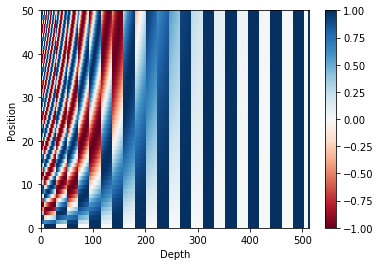

In [23]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Masking

In [24]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [25]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: id=90, shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [26]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [27]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: id=105, shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## Scaled dot product attention

In [28]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [29]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

In [30]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [31]:
# This query aligns with a repeated key (third and fourth), 
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [32]:
# This query aligns equally with the first and second key, 
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


In [33]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## Multi-head attention

In [34]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

In [35]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=4)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 4, 60, 60]))

## Point wise feed forward network

In [36]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [37]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## Encoder

Classify の場合にはDecoderは不要です。Encoderで得られた値をDenseレイヤーで識別したいクラスの次元数に変換します。  
識別次元数は後述のTransformerクラスで指定します。

### Encoder layer

In [38]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):
  
    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    print("enclayer{}".format(out2))
    
    return out2

In [39]:
sample_encoder_layer = EncoderLayer(512, 4, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 50, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

enclayer[[[-2.0834405  -1.0300252  -0.1741553  ... -0.06229966 -1.2399325
    1.0828809 ]
  [-1.7448708   0.12525414  0.543293   ... -0.12575208 -1.3769172
   -0.10517594]
  [-2.4775033  -0.87753296  0.4187556  ...  0.4560355  -1.1538932
   -0.39094928]
  ...
  [-2.7037807  -0.59265363  1.3174944  ...  0.97778565 -0.06441326
   -0.14713241]
  [-3.170845   -0.03727812  0.46580327 ... -0.6322407  -0.65904194
    0.49796346]
  [-1.5496151   0.33932534  1.3378816  ... -0.71698743 -1.2024767
   -0.33123875]]

 [[-2.4474008  -0.19748661  0.10706774 ...  0.9724556  -0.3125562
   -0.49751332]
  [-2.5132384   0.03736693 -0.27704298 ...  0.00006226 -0.41231614
   -0.15279825]
  [-1.430855   -0.45082793  0.05674639 ... -0.26094955 -1.4194609
   -0.36083037]
  ...
  [-1.6272471  -1.2372009   1.4755344  ... -0.88649535 -1.6600608
   -0.15201743]
  [-3.2709053   0.10109807  0.09459713 ... -0.2135497  -0.4190892
   -0.37769848]
  [-1.0231012  -0.89065176  0.98154336 ...  0.9497022   0.29553625
    0.

TensorShape([64, 50, 512])

###  Encoder

In [40]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
           
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    #attention_weights = {}
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    print(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    print(x)
    x += self.pos_encoding[:, :seq_len, :]
    print(x)

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
        x = self.enc_layers[i](x, training, mask)
        #attention_weights['encoder_layer{}'.format(i+1)] = att_weights
       
    return x  # (batch_size, input_seq_len, d_model)

In [41]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

tf.Tensor(
[[[-0.0463562  -0.02120737 -0.03844105 ...  0.03843332  0.0448066
   -0.0366533 ]
  [-0.0463562  -0.02120737 -0.03844105 ...  0.03843332  0.0448066
   -0.0366533 ]
  [-0.01927391 -0.02101152 -0.01342654 ...  0.04100287 -0.04463479
    0.00537199]
  ...
  [ 0.0122028   0.01371484 -0.01202333 ...  0.03167364 -0.00260065
    0.02256769]
  [-0.04638211 -0.01874556 -0.04164172 ...  0.00914273  0.02453936
   -0.02459015]
  [-0.04578899 -0.00214214  0.03824297 ...  0.03318031  0.03028693
   -0.00900459]]

 [[ 0.01717262  0.04633851  0.03025058 ... -0.02342327  0.03626436
    0.01136678]
  [ 0.01889401 -0.026845    0.0452971  ... -0.04426596 -0.0249265
   -0.0092419 ]
  [-0.03689654 -0.03322208  0.03270147 ...  0.04639596 -0.03885832
   -0.04683579]
  ...
  [-0.04427665  0.04218674 -0.00408813 ... -0.0384611   0.04588074
   -0.02183632]
  [ 0.01169684 -0.00852114  0.01095955 ... -0.00090545 -0.04285091
    0.02159221]
  [-0.03783219  0.02224031 -0.03400737 ... -0.04354183  0.0468554

enclayer[[[-1.2154737   0.70685196 -0.72586066 ...  0.41948298  1.1634386
   -0.5591684 ]
  [-0.50794035  0.24107726 -0.12693532 ...  0.35650682  1.1417769
   -0.55016124]
  [-0.6208773  -0.00621739  1.2476473  ...  1.2497021  -1.1699246
   -0.23215744]
  ...
  [-0.40387338  0.5239611   0.8893846  ... -0.13087429 -0.07436439
    0.17631145]
  [-2.2116308  -0.92828614  0.8330687  ... -0.14017974  0.5765187
   -0.90244263]
  [-2.681071    0.04380117  1.6103266  ...  0.5833101   0.11236396
   -0.43253544]]

 [[-0.76445776  1.8559761   0.5809589  ... -0.51997226  1.8705236
   -0.69776523]
  [-0.74179745  0.13211066  1.6109283  ... -0.85574216  0.12193333
   -0.6488891 ]
  [-1.3005269  -1.2510096   1.0072612  ...  0.93910635 -0.35406828
   -1.2998416 ]
  ...
  [-0.95745414  0.27226442  0.9356301  ... -0.7559179   1.0563735
   -1.1039505 ]
  [-1.1893078  -0.04201182  1.549523   ... -0.05166121 -0.36918557
   -0.60133576]
  [-2.6842818   0.6199502   0.22093883 ... -0.9353776   1.5717639
    0

## Create the Transformer

In [42]:
NUMLABELS = 9

In [43]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)
    self.dense1 = tf.keras.layers.Dense(d_model, activation='tanh')
    self.dropout1 = tf.keras.layers.Dropout(rate)   
    self.final_layer = tf.keras.layers.Dense(NUMLABELS, activation='softmax')
    
    
  def call(self, inp, tar, training, enc_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

    enc_output = self.dense1(enc_output[:,0])
    enc_output = self.dropout1(enc_output, training=training)
    final_output = self.final_layer(enc_output )  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output

In [44]:
sample_transformer = Transformer(
    num_layers=4, d_model=128, num_heads=8, dff=512, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

fn_out = sample_transformer(temp_input, temp_target, training=False, enc_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

tf.Tensor(
[[[-0.00177562 -0.02500053  0.04670359 ... -0.01514695  0.01579225
   -0.02655467]
  [-0.018276    0.04129461 -0.00646176 ... -0.04111164 -0.03607183
   -0.00413205]
  [ 0.01448491  0.0064376  -0.02155755 ...  0.01504343  0.00305927
   -0.03701561]
  ...
  [ 0.04541421 -0.04529327 -0.01011185 ... -0.0074895  -0.02637888
   -0.00609846]
  [-0.00065511  0.02327379  0.00330907 ... -0.03683498  0.01690533
    0.04326364]
  [-0.02586588  0.03224764  0.00707807 ...  0.01323884  0.00767555
   -0.01258612]]

 [[-0.0015808   0.04059566 -0.00846351 ... -0.00838293  0.01077678
   -0.03399276]
  [ 0.0119129  -0.04294436  0.04143076 ...  0.01031556  0.03832951
   -0.04083755]
  [-0.00791589 -0.04362534  0.02015418 ...  0.0368284   0.02396066
    0.03697348]
  ...
  [ 0.01234523  0.02196661 -0.00245269 ...  0.04988761  0.00138275
    0.04961752]
  [ 0.03881028 -0.04849702 -0.03558432 ... -0.01026237 -0.03187171
   -0.01543834]
  [-0.00700015 -0.01389717  0.02260406 ... -0.04310315 -0.0131

enclayer[[[-1.0300492   0.44650328 -0.07738053 ...  1.3798735  -0.65192616
    0.38384616]
  [-0.61110157  0.51519024  0.5566396  ...  1.08826    -1.0159655
    0.3807307 ]
  [-0.21648444 -0.5992417   0.1421769  ...  1.1345146  -0.49592096
    0.17734917]
  ...
  [-0.9430423  -0.5595845   0.02572055 ...  1.7001102  -1.0923585
    0.02475087]
  [-1.9107895   0.42423606  0.58987266 ...  1.4081091  -0.6961463
    0.818498  ]
  [-2.4785006   0.7046471   0.26790714 ...  1.1084448  -0.41910106
    0.60006493]]

 [[-0.93804497  0.78428274 -0.5574186  ...  0.76878506 -1.0366867
    0.47474533]
  [-0.5423832  -0.00184368  0.436684   ...  1.0607964  -0.33789685
    0.42361036]
  [-0.91678    -0.5436331   0.288868   ...  1.6298829  -0.6547226
    0.50520223]
  ...
  [-1.0333136   0.02878682  0.32777122 ...  1.669482   -0.9873772
    0.55991644]
  [-1.7031754  -0.18787175  0.28544566 ...  1.2009535  -0.7270464
    0.51711214]
  [-2.1484997   0.45221215  0.46486312 ...  0.85624206 -0.6045534
    0.

TensorShape([64, 9])

## Set hyperparameters

In [45]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = encoder.vocab_size + 2
target_vocab_size = encoder.vocab_size + 2
dropout_rate = 0.1

In [46]:
input_vocab_size

77201

## Optimizer

In [47]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [48]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

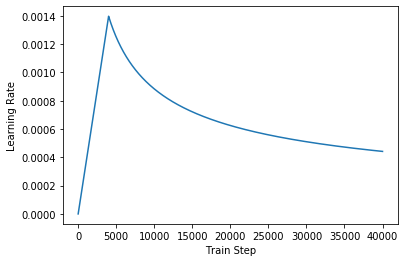

In [49]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [50]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

In [51]:
def loss_function(labels, pred):
  loss_ = loss_object(labels, pred)
  return loss_

In [52]:
#Computes the (weighted) mean of the given values
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

## Training and checkpointing

In [53]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [54]:
def create_masks(inp):
  enc_padding_mask = create_padding_mask(inp)
  return enc_padding_mask

In [55]:
CKPTPATH = "../output/checkpoints/"

In [56]:
ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, CKPTPATH, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [90]:
EPOCHS = 100

In [58]:
train_loss_results = []
train_accuracy_results = []
val_loss_results = []
val_accuracy_results = []

In [59]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=([None, None]), dtype=tf.int64),
    tf.TensorSpec(shape=([None]), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  
  enc_padding_mask = create_masks(inp)
  
  with tf.GradientTape() as tape:
    predictions = transformer(inp, tar, True, enc_padding_mask)        
    loss = loss_function(tar, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables) 
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar, predictions)

In [60]:
val_step_signature = [
    tf.TensorSpec(shape=([None, None]), dtype=tf.int64),
    tf.TensorSpec(shape=([None]), dtype=tf.int64),
]

@tf.function(input_signature=val_step_signature)
def val_step(inp, tar):
  enc_padding_mask = create_masks(inp)
  predictions = transformer(inp, tar, False, enc_padding_mask)
  loss = loss_function(tar, predictions)
  val_loss(loss)
  val_accuracy(tar, predictions)

In [91]:
for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # inp -> dataset.tokes, tar -> dataset.target
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))

  for (batch, (inp, tar)) in enumerate(val_dataset):
    val_step(inp, tar)
     
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f} VAL_Loss {:.4f} VAL_Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result(),
                                                val_loss.result(),
                                                val_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))
    
  train_loss_results.append(train_loss.result())
  train_accuracy_results.append(train_accuracy.result())
  val_loss_results.append(val_loss.result())
  val_accuracy_results.append(val_accuracy.result())

Epoch 1 Batch 0 Loss 1.4091 Accuracy 0.5000
Epoch 1 Loss 1.4091 Accuracy 0.5000 VAL_Loss 1.9951 VAL_Accuracy 0.3112
Time taken for 1 epoch: 2.1425108909606934 secs

Epoch 2 Batch 0 Loss 1.3554 Accuracy 0.5417
Epoch 2 Loss 1.3554 Accuracy 0.5417 VAL_Loss 1.9934 VAL_Accuracy 0.3123
Time taken for 1 epoch: 1.6694679260253906 secs

Epoch 3 Batch 0 Loss 1.2756 Accuracy 0.5833
Epoch 3 Loss 1.2756 Accuracy 0.5833 VAL_Loss 1.9919 VAL_Accuracy 0.3135
Time taken for 1 epoch: 1.512718915939331 secs

Epoch 4 Batch 0 Loss 1.2600 Accuracy 0.6250
Epoch 4 Loss 1.2600 Accuracy 0.6250 VAL_Loss 1.9904 VAL_Accuracy 0.3146
Time taken for 1 epoch: 1.5617151260375977 secs

Epoch 5 Batch 0 Loss 1.3298 Accuracy 0.5417
Saving checkpoint for epoch 5 at ../output/checkpoints/ckpt-21
Epoch 5 Loss 1.3298 Accuracy 0.5417 VAL_Loss 1.9891 VAL_Accuracy 0.3156
Time taken for 1 epoch: 2.643768072128296 secs

Epoch 6 Batch 0 Loss 1.3323 Accuracy 0.5000
Epoch 6 Loss 1.3323 Accuracy 0.5000 VAL_Loss 1.9880 VAL_Accuracy 0.316

Epoch 47 Batch 0 Loss 0.5513 Accuracy 0.8958
Epoch 47 Loss 0.5513 Accuracy 0.8958 VAL_Loss 2.0015 VAL_Accuracy 0.3120
Time taken for 1 epoch: 1.571124792098999 secs

Epoch 48 Batch 0 Loss 0.6520 Accuracy 0.8125
Epoch 48 Loss 0.6520 Accuracy 0.8125 VAL_Loss 2.0031 VAL_Accuracy 0.3118
Time taken for 1 epoch: 1.5428235530853271 secs

Epoch 49 Batch 0 Loss 0.5418 Accuracy 0.8958
Epoch 49 Loss 0.5418 Accuracy 0.8958 VAL_Loss 2.0048 VAL_Accuracy 0.3116
Time taken for 1 epoch: 1.5305464267730713 secs

Epoch 50 Batch 0 Loss 0.5386 Accuracy 0.8750
Saving checkpoint for epoch 50 at ../output/checkpoints/ckpt-30
Epoch 50 Loss 0.5386 Accuracy 0.8750 VAL_Loss 2.0066 VAL_Accuracy 0.3114
Time taken for 1 epoch: 2.392813205718994 secs

Epoch 51 Batch 0 Loss 0.4621 Accuracy 0.8958
Epoch 51 Loss 0.4621 Accuracy 0.8958 VAL_Loss 2.0085 VAL_Accuracy 0.3113
Time taken for 1 epoch: 1.5921223163604736 secs

Epoch 52 Batch 0 Loss 0.4986 Accuracy 0.8958
Epoch 52 Loss 0.4986 Accuracy 0.8958 VAL_Loss 2.0107 VAL_A

Epoch 93 Batch 0 Loss 0.1079 Accuracy 1.0000
Epoch 93 Loss 0.1079 Accuracy 1.0000 VAL_Loss 2.1724 VAL_Accuracy 0.3013
Time taken for 1 epoch: 1.5290532112121582 secs

Epoch 94 Batch 0 Loss 0.0978 Accuracy 1.0000
Epoch 94 Loss 0.0978 Accuracy 1.0000 VAL_Loss 2.1775 VAL_Accuracy 0.3004
Time taken for 1 epoch: 1.5493850708007812 secs

Epoch 95 Batch 0 Loss 0.1358 Accuracy 0.9792
Saving checkpoint for epoch 95 at ../output/checkpoints/ckpt-39
Epoch 95 Loss 0.1358 Accuracy 0.9792 VAL_Loss 2.1823 VAL_Accuracy 0.2996
Time taken for 1 epoch: 2.3558714389801025 secs

Epoch 96 Batch 0 Loss 0.1125 Accuracy 1.0000
Epoch 96 Loss 0.1125 Accuracy 1.0000 VAL_Loss 2.1865 VAL_Accuracy 0.2988
Time taken for 1 epoch: 1.6018650531768799 secs

Epoch 97 Batch 0 Loss 0.0849 Accuracy 1.0000
Epoch 97 Loss 0.0849 Accuracy 1.0000 VAL_Loss 2.1901 VAL_Accuracy 0.2988
Time taken for 1 epoch: 1.626584768295288 secs

Epoch 98 Batch 0 Loss 0.1009 Accuracy 0.9792
Epoch 98 Loss 0.1009 Accuracy 0.9792 VAL_Loss 2.1934 VAL_

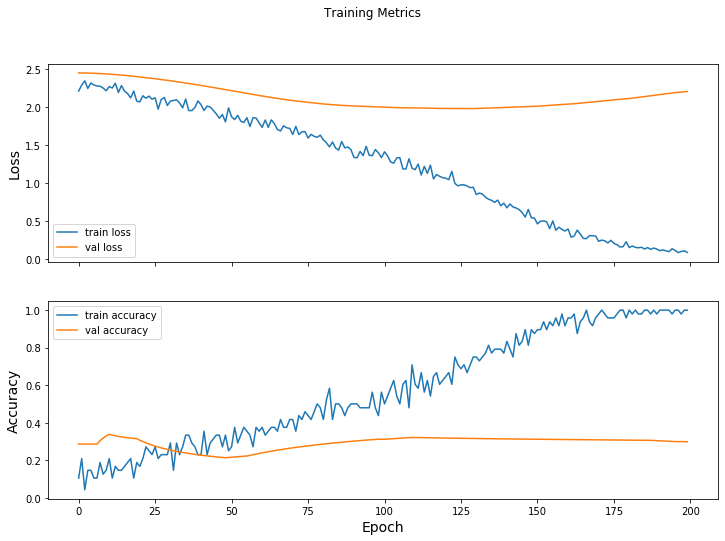

In [92]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results,label='train loss')
axes[0].plot(val_loss_results, label='val loss')
axes[0].legend()

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results, label='train accuracy')
axes[1].plot(val_accuracy_results, label='val accuracy')
axes[1].legend()
plt.show()

In [75]:
transformer.summary()

Model: "transformer_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_2 (Encoder)          multiple                  10674816  
_________________________________________________________________
dense_74 (Dense)             multiple                  16512     
_________________________________________________________________
dropout_26 (Dropout)         multiple                  0         
_________________________________________________________________
dense_75 (Dense)             multiple                  1161      
Total params: 10,692,489
Trainable params: 10,692,489
Non-trainable params: 0
_________________________________________________________________


## Evaluate

In [89]:
def evaluate(filename, tar):
  
  with open(filename) as text_file:
    # 0: URL, 1: timestamp
    text = text_file.readlines()[2:]
    text = [sentence.strip() for sentence in text]
    text = list(filter(lambda line: line != '', text))
    text = ''.join(text)
    print(text)
  
  table = str.maketrans({
    '\n': '',
    '\t': '　',
    '\r': '',
  })
  text = text.translate(table)

  text = preprocessing(text)
  text = parse(text)
  print(text)
  
  start_token = [encoder.vocab_size]
  end_token = [encoder.vocab_size + 1]
      
  tokens = start_token + encoder.encode(text) + end_token
  inp = tokens[0:140]
  encoder_input = tf.expand_dims(inp, 0)
  print(inp)

  # predictions.shape == (batch_size, seq_len, vocab_size)
  enc_padding_mask = create_masks(encoder_input)
  predictions = transformer(encoder_input, tar, False, enc_padding_mask)
  predictions = predictions[0:, :]

  array_pred = predictions.numpy()
  print("predictions : {}".format(array_pred))
  print("sort by predictions : {}".format(np.sort(array_pred)))
  print("sort by target : {}".format(np.argsort(array_pred)))
  
  return np.argmax(predictions.numpy())

In [87]:
evaluate("../input/data/livedoor/text/it-life-hack/it-life-hack-6296655.txt", "it-life-hack")

忘れそうになってた！孫社長の格言的な言葉が話題ソフトバンクグループの代表 孫正義氏は、Twitterを通じて活発な発言をしている。そんな同氏の格言的な発言がネットで話題となっている。それは、突然のつぶやきから始まった。孫社長は、「己の限界は己の考え方が決めてしまうものである。」と、つぶやいた。このつぶやきに対して、下記のコメントが寄せられている。「いつも応援いたします」「そして、考え方って誰に出逢うか。によって変わりますよね。」「今の日本人が気にしなくなってきた事かな。」「そうだなー、考えるのさえ止めてるってのもかっこ悪いぜ。ヒップホップも生きるスタイルなんだ。」「忘れそうになってた。ありがと。 」「ですねぇ。」「その通りだ！自戒を込めて！」「そんなことあるわけない。こういう平和な限界論は、いい加減、止めて欲しい。」「孫正義うーん孫さんの言う通りだな。限界決めずに突っ走るしかない、2，3月はｗ　限界突破」「僕は自分の限界は自分で決めません。自分は無限の可能性があると信じてますから！自分が自分の一番の理解者だから。」「同意」様々な意見が寄せられている。■孫正義 (masason) on Twitter■孫社長に関連した記事をもっと見る・豪快な笑いって大好き！孫社長の人生は楽しい発言が話題・夢を捨てて何の為の人生だ！孫社長の人生論に共感の嵐・好き嫌いはアートなのか！孫社長の格言的な言葉に賛否両論・都心では今後4年で百倍の情報量！孫社長の危機発言がネットで話題・おっしゃる通りです！孫社長 原発事故の危機発言が話題孫正義 奇跡のプレゼン　人を動かす23の法則著者：三木 雄信ソフトバンククリエイティブ(2011-12-01)販売元：Amazon.co.jpクチコミを見る
忘れ　そうに　なって　た　孫　社長　の　格言　的な　言葉　が　話題　ソフト　バンク　グループ　の　代表　　　孫　正義　氏　は　ｔｗｉｔｔｅｒ　を　通じて　活発な　発言　を　して　いる　そんな　同　氏　の　格言　的な　発言　が　ネット　で　話題　と　なって　いる　それ　は　突然の　つぶやき　から　始まった　孫　社長　は　己　の　限界　は　己　の　考え　方　が　決めて　しまう　もの　である　と　つぶやいた　この　つぶやき　に　対して　下記　の　コメント　が　寄せ　られて　いる　いつも　応援　いたし　ます　そして　

2

In [88]:
evaluate("../input/data/livedoor/text/sports-watch/sports-watch-6651544.txt", "sports-watch")

日本×オーストラリア戦、レフェリーの不可解判定に言及12日、サッカーW杯アジア最終予選＝日本対オーストラリア戦がオーストラリア・クイーンズランド州ブリスベンで行われ、試合は1-1の引き分けに終わった。日本は本田圭佑の絶妙なパスから栗原勇蔵のゴールで先制するも、内田篤人がレフェリーに不可解なファールを取られ、オーストラリアにPKを与える格好となったばかりか、試合終了間際には、日本がフリーキックを獲得するも、本田が蹴る前に試合終了のホイッスルを吹くなど、疑問の残る場面が何度か見られた。同日、テレビ朝日「報道ステーション」では、サッカー解説者・澤登正朗氏が試合を振り返りつつ、内田が取られたファール、そして、ロスタイムでフリーキックを蹴る直前で試合終了としたレフェリングについて言及した。「僕もちょっとおかしな判定が多いなと思ったんですけど、レフェリーはスタジアムの雰囲気にのまれて、少し冷静さを失っていた部分があったのかもしれない」と語る澤登氏は、内田が与えたとされるファールについて「僕も見てて、これはファールではないんじゃないかと思うんですけど、ただレフェリーの判定というのは絶対ですので、これは受け入れなければいけないのかもしれないですね」と続けた。また、「恐らく内田としても手で掴んだということではないと思うんですけど、その辺り、レフェリーが見ていたのかもしれないですね」とフォローした澤登氏は、フリーキック前の試合終了に、「本当はですね、もちろんフリーキックを蹴った後に、ホイッスルが鳴る筈なんですけど、この辺りもレフェリーが冷静さを欠いていて、試合を終えてしまったのかなという感じ」と話し、いずれも“レフェリーが冷静さを欠いてた”と指摘した。
日本　×　オーストラリア　戦　レフェリー　の　不可解　判定　に　言及　０　日　サッカー　ｗ杯　アジア　最終　予選　＝　日本　対　オーストラリア　戦　が　オーストラリア　クイーンズランド　州　ブリスベン　で　行わ　れ　試合　は　０　－　０　の　引き分け　に　終わった　日本　は　本田　圭佑　の　絶妙な　パス　から　栗原　勇蔵　の　ゴール　で　先制　する　も　内田　篤人　が　レフェリー　に　不可解な　ファール　を　取ら　れ　オーストラリア　に　ｐｋ　を　与える　格好　と　なった　ばかり　か　試合　終了　間際　に　は　日本　が　フリー　キック　

2